# Training of a mit-b4 SegFormer

This is a notebook to fine-tune a pre-trained mit-b4 SegFormer for the semantic segmentation tasks of the HuBMAP-HPA kaggle competition. A rescaled dataset of the original competition dataset is used. The rescale has been done at 1024x1024 resolution.

Heavy augmentations* were used. The main technique that gave a significant boost to the training's accuracy is `RandomCutOut` with 8 holes and high probability of 0.5.

This configuration, with only 10,000, iterations gave a final Dice score of `mDice: 0.9322, Dice.BG: 0.9875, Dice.FTU: 0.8769`.

The model was trained on a single Tesla T4 GPU and it took about 2:20 hours.

Finally, a kaggle dataset was created with the produced model and all the log files and uploaded to kaggle.



<small>*The augmentations were mainly inspired by [Kobayashi_yitse](https://www.kaggle.com/adc28827810)'s notebook.</small> 

## Installing all prerequisites for an MMSegmentation model

In [ ]:
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 GB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0
    Uninstalling torch-1.13.0:
      Successfully uninstalled torch-1.13.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0
    Uninstalling torchvision-0.14.0:
      Successfully uninstalled torchvision-0.14.0
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.13.0
    Uninstalling torchaudio-0.13.0:
      Successfully uninstalled torchaudio-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is t

In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)
!python -V
!nvcc --version

1.11.0+cu113
11.3
Python 3.9.16
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!pip install mmcv-full==1.5.0 -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.11.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.4/37.4 MB 19.5 MB/s eta 0:00:00
  Attempting uninstall: mmcv-full
    Found existing installation: mmcv-full 1.7.0
    Uninstalling mmcv-full-1.7.0:
      Successfully uninstalled mmcv-full-1.7.0


In [ ]:
%cd /content
!rm -rf /content/mmsegmentation
!git clone -b main https://github.com/open-mmlab/mmsegmentation.git --branch v0.26.0
%cd mmsegmentation
!pip install -e .

/content
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 14686, done.
remote: Counting objects: 100% (273/273), done.
remote: Compressing objects: 100% (201/201), done.
remote: Total 14686 (delta 93), reused 155 (delta 67), pack-reused 14413
Receiving objects: 100% (14686/14686), 18.33 MiB | 10.40 MiB/s, done.
Resolving deltas: 100% (10392/10392), done.
Note: switching to '17056b636f61b6887d72f492178b0399a46ab4d8'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

/content/mmsegmentation
Looking in indexes: https:

## The HuBMAP-HPA 1024x1024 dataset

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle

In [ ]:
%%bash
cat <<EOT > ~/.kaggle/kaggle.json
{"username":"YOUR_USER_NAME_HERE","key":"YOUR_KEY_HERE"}
EOT

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json
!ls -lha ~/.kaggle/kaggle.json

-rw------- 1 root root 63 Apr 16 19:44 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d theo88/hubmap-hpa-1024x1024-png-dataset

100% 718M/721M [00:18<00:00, 44.2MB/s]
100% 721M/721M [00:18<00:00, 40.9MB/s]


In [ ]:
%%bash
cd /content/mmsegmentation

mkdir -p data/HubMAP
unzip -q hubmap-hpa-1024x1024-png-dataset.zip -d data/HubMAP

In [ ]:
!ls data/HubMAP/HuBMAP-HPA-1024x1024-PNG/train | grep png | wc -l
!ls data/HubMAP/HuBMAP-HPA-1024x1024-PNG/masks | grep png | wc -l

351
351


A few samples of the images with their respective masks

(1024, 1024) [0 1]
(1024, 1024) [0 1]
(1024, 1024) [0 1]


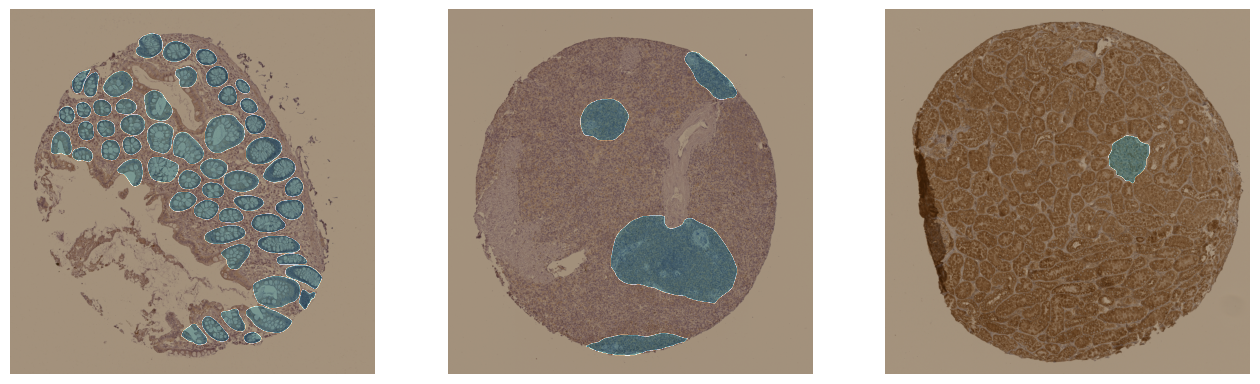

In [ ]:
DATA_PATH = "data/HubMAP/HuBMAP-HPA-1024x1024-PNG"
import numpy as np
import matplotlib.pyplot as plt
import cv2

sample_ids = [9904, 9453, 9445]
def display_samples(sample_ids):
    plt.figure(figsize=(16, 16))
    for ind, img_id in enumerate(sample_ids):
      ax = plt.subplot(1, 3, ind+1)
      image = cv2.imread(f"{DATA_PATH}/train/{img_id}.png")
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      mask = cv2.imread(f"{DATA_PATH}/masks/{img_id}.png", cv2.IMREAD_UNCHANGED)
      print(mask.shape, np.unique(mask)) # Should be (1024, 1024) [0 1]
      plt.imshow(image)
      plt.imshow(mask, cmap="BrBG", alpha=0.5)
      plt.axis("off")

display_samples(sample_ids)
plt.show()


## Training the model

### Preapring the training and validation  datasets

In [ ]:
import os
from glob import glob
from sklearn.model_selection import train_test_split

all_mask_files = glob(f"{DATA_PATH}/masks/*")
train_files, val_files = train_test_split(all_mask_files, test_size=0.2, random_state=42)
with open(f"{DATA_PATH}/train_set.txt", "w") as f:
    for file_name in train_files:
        f.write(os.path.basename(file_name)[:-4] + "\n")
with open(f"{DATA_PATH}/val_set.txt", "w") as f:
    for file_name in val_files:
        f.write(os.path.basename(file_name)[:-4] + "\n")
!wc -l {DATA_PATH}/train_set.txt
!wc -l {DATA_PATH}/val_set.txt

280 data/HubMAP/HuBMAP-HPA-1024x1024-PNG/train_set.txt
71 data/HubMAP/HuBMAP-HPA-1024x1024-PNG/val_set.txt


### Configuration files of the SegFormer

In [ ]:
%%bash

cat <<EOT > configs/segformer/segformer_HuBMAP.py
_base_ = [
    '../_base_/datasets/HubMAP.py',
    '../_base_/default_runtime.py', '../_base_/schedules/HubMAP.py'
]

checkpoint = 'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segformer/mit_b4_20220624-d588d980.pth'
norm_cfg = dict(type='SyncBN', requires_grad=True)
backbone_norm_cfg = dict(type='LN', requires_grad=True)
model = model = dict(
                type='EncoderDecoder',
                pretrained=None,
                backbone=dict(
                    type='MixVisionTransformer',
                    init_cfg=dict(type='Pretrained', checkpoint=checkpoint),
                    in_channels=3,
                    embed_dims=64,
                    num_stages=4,
                    num_layers=[3, 8, 27, 3],
                    num_heads=[1, 2, 5, 8],
                    patch_sizes=[7, 3, 3, 3],
                    sr_ratios=[8, 4, 2, 1],
                    out_indices=(0, 1, 2, 3),
                    mlp_ratio=4,
                    qkv_bias=True,
                    drop_rate=0.1,
                    attn_drop_rate=0.1,
                    drop_path_rate=0.1),
                decode_head=dict(
                      type='SegformerHead',
                      in_channels=[64, 128, 320, 512],
                      in_index=[0, 1, 2, 3],
                      channels=512,
                      dropout_ratio=0.1,
                      num_classes=2,
                      norm_cfg=norm_cfg,
                      align_corners=False,
                      loss_decode=[
                          dict(type='CrossEntropyLoss', loss_name='loss_ce', loss_weight=1.0),
                          dict(type='DiceLoss', loss_name='loss_dice', loss_weight=3.0)
                          ]),
    # model training and testing settings
    train_cfg=dict(),
    test_cfg=dict(mode='whole'))


# optimizer
optimizer = dict(
    type='AdamW',
    lr=6e-5,
    betas=(0.9, 0.999),
    weight_decay=0.05,
    paramwise_cfg=dict(custom_keys=dict(head=dict(lr_mult=10.0)))
)
optimizer_config = dict(type='Fp16OptimizerHook', loss_scale='dynamic')
lr_config = dict(
    policy='poly',
    warmup='linear',
    warmup_iters=1000,
    warmup_ratio=1e-6,
    power=1.0,
    min_lr=0.0,
    by_epoch=False)

data = dict(samples_per_gpu=1, workers_per_gpu=2)
EOT

In [ ]:
%%bash
cat <<EOT > configs/_base_/schedules/HubMAP.py

total_iters = 10000
find_unused_parameters = True
runner = dict(type = 'IterBasedRunner', max_iters = total_iters)
checkpoint_config = dict(by_epoch=False, interval=-1, save_optimizer=False)
evaluation = dict(by_epoch=False, interval=1000, metric='mDice', pre_eval=True)
seed = 88 # Will not work, it is overwritten by tools/train.py arguments
deterministic = True # same for deterministic
EOT

In [ ]:
%%bash
cat <<EOT > configs/_base_/datasets/HubMAP.py
# dataset settings
dataset_type = 'CustomDataset'
data_root = 'data/HubMAP/HuBMAP-HPA-1024x1024-PNG'
img_norm_cfg = dict(mean=[211.20151643, 204.67735042, 209.23892375], std=[43.26604051, 50.07292728, 47.15776597], to_rgb=True)
size = 1024
classes = ['BG', 'FTU']
palette = [[0,0,0], [255,0,0]]
crop_size = (768, 768)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=[(640, 640), (768, 768)], keep_ratio=False),
    dict(type='RandomFlip', prob=0.5, direction='horizontal'),
    dict(type='CLAHE', clip_limit=2),
    dict(type='RandomCrop', crop_size=crop_size, cat_max_ratio=0.5),
    dict(type='RandomFlip', prob=0.5, direction='vertical'),
    dict(type='RandomCutOut', prob=0.5, n_holes=8, cutout_ratio=(0.2, 0.4)),
    dict(type='AdjustGamma'),
    dict(type='RandomRotate', prob=0.5, degree=30),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size=crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(size, size),
        img_ratios=[0.8, 1.0, 1.2],
        flip=True,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32, pad_val=0, seg_pad_val=255),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]
data = dict(
    train=dict(
        type=dataset_type,
        data_root=data_root,
        img_dir='train',
        ann_dir='masks',
        img_suffix=".png",
        seg_map_suffix='.png',
        split="train_set.txt",
        classes=classes,
        palette=palette,
        pipeline=train_pipeline),
    val=dict(
        type=dataset_type,
        data_root=data_root,
        img_dir='train',
        ann_dir='masks',
        img_suffix=".png",
        seg_map_suffix='.png',
        split="val_set.txt",
        classes=classes,
        palette=palette,
        pipeline=test_pipeline),
    test=dict(
        type=dataset_type,
        data_root=data_root,
        test_mode=True,
        img_dir='train',
        ann_dir='masks',
        img_suffix=".png",
        seg_map_suffix='.png',
        classes=classes,
        palette=palette,
        pipeline=test_pipeline))

EOT

### Training on a single GPU

A deterministic method with a fixed seed is used for reproducability

In [ ]:
# Single-gpu training
# HubMAP
!python tools/train.py configs/segformer/segformer_HuBMAP.py --seed 88 --deterministic

2023-04-16 20:20:49,034 - mmseg - INFO - Multi-processing start method is `None`
2023-04-16 20:20:49,034 - mmseg - INFO - OpenCV num_threads is `2
2023-04-16 20:20:49,065 - mmseg - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.9.16 (main, Dec  7 2022, 01:11:51) [GCC 9.4.0]
CUDA available: True
GPU 0: Tesla T4
CUDA_HOME: /usr/local/cuda
NVCC: Cuda compilation tools, release 11.8, V11.8.89
GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
PyTorch: 1.11.0+cu113
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.5.2 (Git Hash a9302535553c73243c632ad3c4c80beec3d19a1e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.3
  - NVCC archi

### Storing the produced model

The model was copied to Google Drive and to a newly created dataset in kaggle.

In [ ]:
! ls -lha work_dirs/segformer_HuBMAP/*.pth

-rw-r--r-- 1 root root 239M Apr 16 22:38 work_dirs/segformer_HuBMAP/iter_10000.pth
lrwxrwxrwx 1 root root   14 Apr 16 22:38 work_dirs/segformer_HuBMAP/latest.pth -> iter_10000.pth


In [ ]:
# mount gDrive
from google.colab import drive
drive.mount('/content/gdrive')
# Copy model to gDrive
!cp work_dirs/segformer_HuBMAP/iter_10000.pth /content/gdrive/YOUR_PATH_HERE/SegFormer_mitb4_1024x1024_9322_No_Albu.pth

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!mv work_dirs/segformer_HuBMAP/iter_10000.pth work_dirs/segformer_HuBMAP/SegFormer_mitb4_1024x1024_9322_No_Albu.pth

In [ ]:
!kaggle datasets init -p /content/mmsegmentation/work_dirs/segformer_HuBMAP

Data package template written to: /content/mmsegmentation/work_dirs/segformer_HuBMAP/dataset-metadata.json


A manual edit of the `dataset-metadata.json` file is needed here.

In [ ]:
!kaggle datasets create -p /content/mmsegmentation/work_dirs/segformer_HuBMAP

Starting upload for file 20230416_202049.log.json
100% 55.0k/55.0k [00:00<00:00, 100kB/s]
Upload successful: 20230416_202049.log.json (55KB)
Starting upload for file 20230416_200944.log
100% 208k/208k [00:00<00:00, 239kB/s]
Upload successful: 20230416_200944.log (208KB)
Starting upload for file segformer_HuBMAP.py
100% 9.04k/9.04k [00:00<00:00, 9.99kB/s]
Upload successful: segformer_HuBMAP.py (9KB)
Starting upload for file 20230416_201302.log
100% 207k/207k [00:00<00:00, 245kB/s]
Upload successful: 20230416_201302.log (207KB)
Skipping: latest.pth
Starting upload for file 20230416_194542.log
100% 208k/208k [00:00<00:00, 287kB/s]
Upload successful: 20230416_194542.log (208KB)
Starting upload for file SegFormer_mitb4_1024x1024_9322_No_Albu.pth
100% 238M/238M [00:07<00:00, 35.2MB/s]
Upload successful: SegFormer_mitb4_1024x1024_9322_No_Albu.pth (238MB)
Starting upload for file 20230416_200839.log
100% 208k/208k [00:00<00:00, 224kB/s]
Upload successful: 20230416_200839.log (208KB)
Starting u